In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


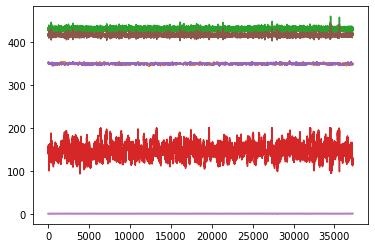

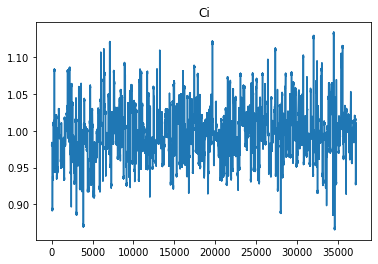

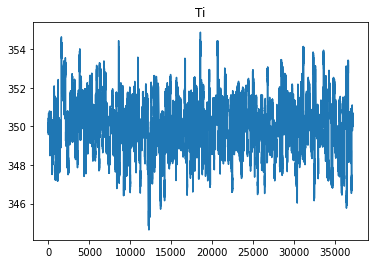

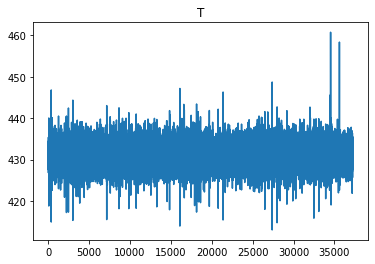

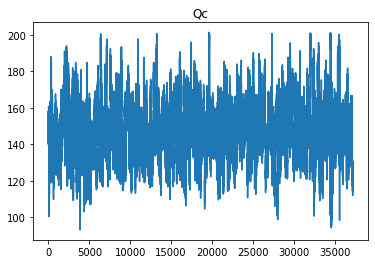

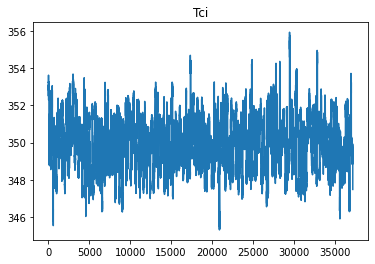

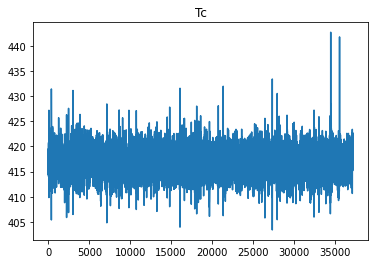

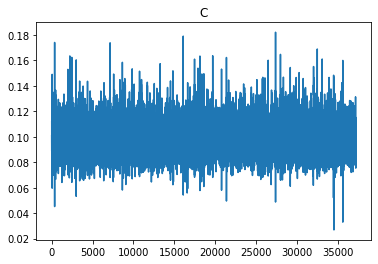

In [2]:
dfRaw = pd.read_excel('Model data.xlsx',engine='openpyxl')
df=dfRaw
# print(dfRaw.shape)
# print(dfRaw.columns)

d=dfRaw.iloc[:,2:9]
plt.plot(d)
plt.show()
name=['Ci', 'Ti', 'T', 'Qc', 'Tci', 'Tc', 'C']

for i in range(7):
    plt.plot(d.iloc[:,i])
    plt.title(name[i], fontdict=None, loc='center', pad=None)
    plt.show()

In [13]:
data = dfRaw.copy()
normal_data = data.loc[data["Class"] == 0]
fault_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fault data ", fault_data.shape)
print("Percent fault ", round((len(fault_data)/len(data)), 4),"%")
a=normal_data.describe().transpose()

from IPython.display import display, HTML

display(HTML(a.to_html()))



data  (37229, 9)
normal_data  (37229, 9)
fault data  (0, 9)
Percent fault  0.0 %


,count,mean,std,min,25%,50%,75%,max
Time,37229.0,599.987053,346.707906,0.000000,300.000000,600.000000,900.000000,1200.000000
Class,37229.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ci,37229.0,0.998449,0.042960,0.865279,0.970107,0.995722,1.025304,1.134271
Ti,37229.0,350.024854,1.404278,344.631969,349.119541,350.058023,350.950739,354.877220
T,37229.0,430.923729,2.517993,412.986640,429.289180,430.890716,432.511530,460.760546
Qc,37229.0,148.306330,15.556881,93.199501,137.796506,147.563258,158.007581,201.376087
Tci,37229.0,349.981567,1.414838,345.319741,348.968001,349.986021,350.939719,355.916121
Tc,37229.0,416.794192,2.214949,403.414096,415.365757,416.805184,418.253873,442.713071
C,37229.0,0.099881,0.010899,0.026845,0.092548,0.099407,0.106578,0.181982


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


------------------------------------------------------------------------
Training for fold 0 ...


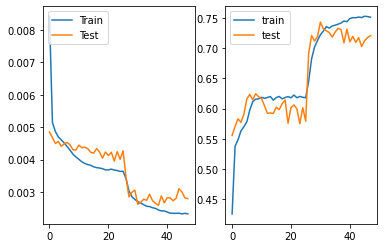

------------------------------------------------------------------------
Training for fold 1 ...


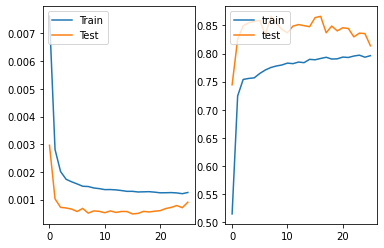

------------------------------------------------------------------------
Training for fold 2 ...


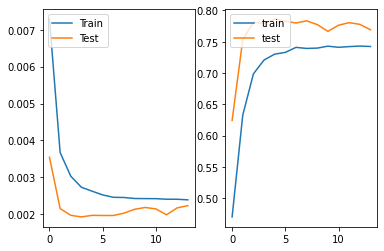

------------------------------------------------------------------------
Training for fold 3 ...


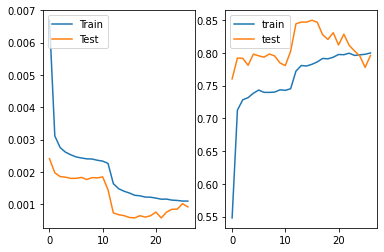

------------------------------------------------------------------------
Training for fold 4 ...


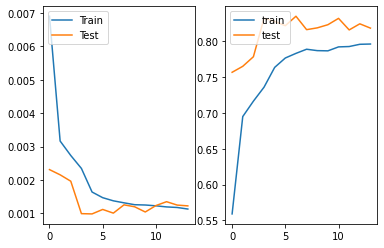

> Loss: 0.0013135295602810016
> acc: [[0.42577982, 0.53762215, 0.5482994, 0.56314003, 0.5700232, 0.5781486, 0.59755564, 0.61138904, 0.6155861, 0.6161569, 0.6187422, 0.6170634, 0.61844003, 0.61998457, 0.6139744, 0.618205, 0.62011886, 0.6161233, 0.6183393, 0.61988384, 0.61786926, 0.6224692, 0.61797, 0.6201524, 0.6187758, 0.61803716, 0.64543533, 0.6822348, 0.7018433, 0.71252054, 0.7223248, 0.7283014, 0.7355874, 0.73320353, 0.73666185, 0.7380049, 0.73965013, 0.74159753, 0.74498874, 0.74384713, 0.74891716, 0.7505288, 0.75032735, 0.7514354, 0.7506631, 0.752812, 0.7522748, 0.75130105], [0.5145553, 0.7244737, 0.7539536, 0.7556996, 0.756774, 0.7645637, 0.77070814, 0.7751738, 0.77785987, 0.779673, 0.782997, 0.7820233, 0.7848437, 0.78380287, 0.7896787, 0.7889064, 0.7912568, 0.79337204, 0.7902159, 0.7905852, 0.79370785, 0.7930363, 0.7955545, 0.7971326, 0.7935064, 0.796226], [0.47026828, 0.6327099, 0.69858646, 0.72074676, 0.7301145, 0.7329349, 0.740926, 0.7392472, 0.7397844, 0.7428399, 0.7410603, 0

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy


from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, preprocessing
from sklearn.model_selection import KFold


df = pd.read_excel('Model data.xlsx',engine='openpyxl')
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()


# This portion of code remove anomalies if the dataset contained anomalies

df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]


normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']




# # scaling
scaler = preprocessing.MinMaxScaler()

scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# # 80% percent of dataset is designated to training
train_data, test_data = train_test_split(scaled_data, test_size=0.3)
n_features = x.shape[1]

inputs = np.concatenate((train_data, test_data), axis=0)


# Define the K-fold Cross Validator
num_folds=5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc=[]
val_acc=[]
prediction_loss_error=[]

i=0

for train, test in kfold.split(inputs):
    
    # # model
    encoder = keras.Sequential(name='encoder')
    encoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu, input_shape=[n_features]))
    encoder.add(keras.layers.Dropout(0.1))
    encoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu))
    encoder.add(layer=keras.layers.Dense(units=5, activation=keras.activations.relu))

    decoder = keras.Sequential(name='decoder')
    decoder.add(layer=keras.layers.Dense(units=10, activation=keras.activations.relu, input_shape=[5]))
    decoder.add(layer=keras.layers.Dense(units=20, activation=keras.activations.relu))
    decoder.add(keras.layers.Dropout(0.1))
    decoder.add(layer=keras.layers.Dense(units=n_features, activation=keras.activations.sigmoid))

    autoencoder = keras.Sequential([encoder, decoder])

    autoencoder.compile(
        loss=keras.losses.MSE,
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.mean_squared_error,'accuracy'])
    

    # train model
    es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, restore_best_weights=True)
#     history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    # Fit data to model
    history = autoencoder.fit(x=inputs[train], y=inputs[train], epochs=50, verbose=0, validation_data=[test_data, test_data], callbacks=[es])
    
    
    # Mean Squared error
    train_predicted_x = autoencoder.predict(x=inputs[train])
    train_events_mse=sklearn.metrics.mean_squared_error(inputs[train], train_predicted_x)

    prediction_loss_error.append(train_events_mse)
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    
    
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
#     ax1.title('Model Loss')
#     ax1.ylabel('Loss')
#     ax1.xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
#     ax2.title('model accuracy')
#     ax2.ylabel('accuracy')
#     ax2.xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')
    plt.show()

    i=i+1


# Increase fold number
i = i + 1

print(f'> Loss: {np.mean(prediction_loss_error)}')
print(f'> acc: {(acc)}')
print(f'> val_acc: {(val_acc)}')

/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


MSE
13.274785041809082
5164.058


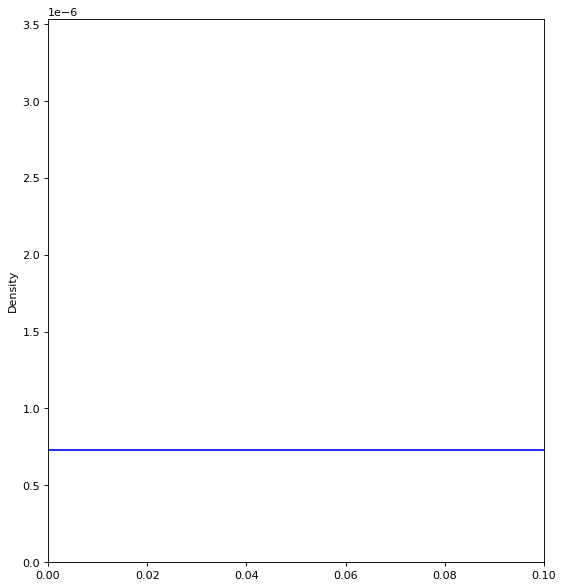

In [5]:

# Mean Squared error
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = keras.losses.mean_absolute_percentage_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

# loss distribution

plt.figure(figsize=(8,9), dpi=80)
sns.distplot(train_events_mse, bins=200, kde=True, color='blue')
plt.xlim([0., .1]);


print('MSE')
print(cut_off)
print(np.average(train_events_mse.numpy()))




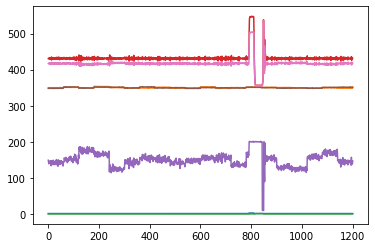

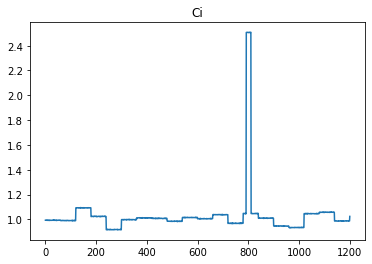

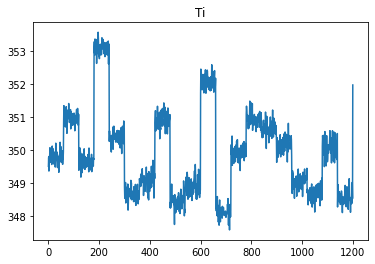

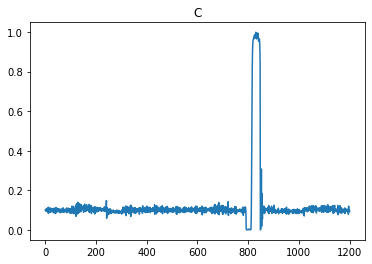

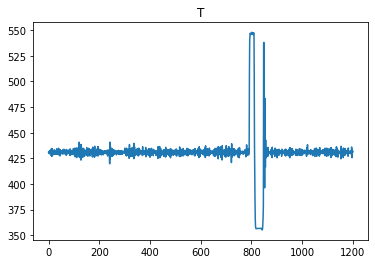

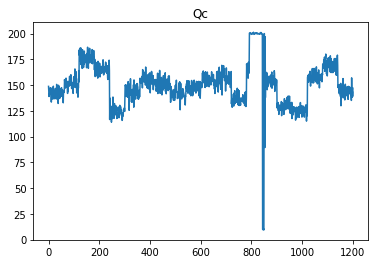

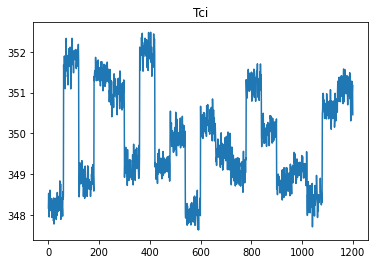

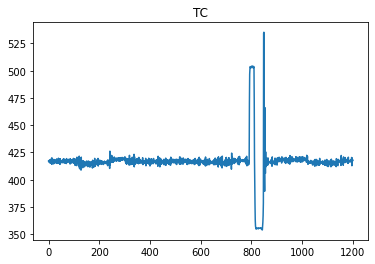

           mse Class
0     6.172542     0
1     6.176354     0
2     6.174603     0
3     6.179759     0
4     6.176095     0
...        ...   ...
1196  6.177341     0
1197  6.200737     0
1198  6.189883     0
1199  6.193863     0
1200  6.203518     0

[1201 rows x 2 columns]


/opt/anaconda3/envs/Autoencoder/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

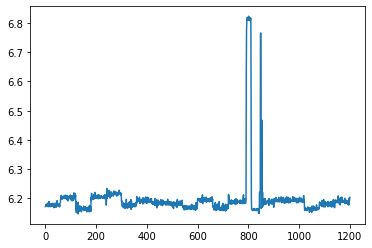

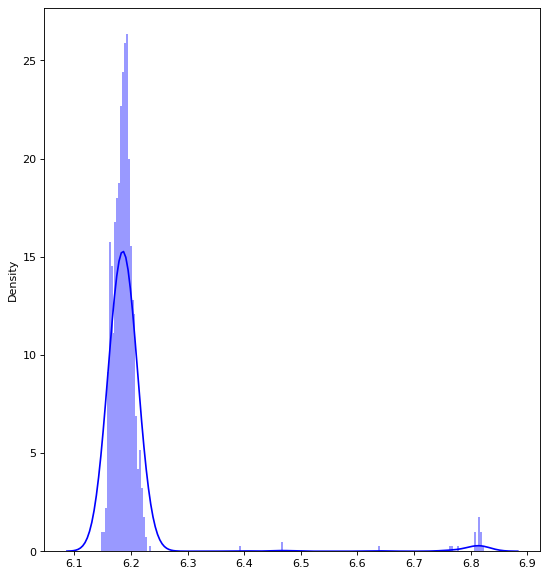

In [38]:
# Import dataset whihc has a fault to be detected

df = pd.read_excel('Input Concentration Fault 1.xlsx',engine='openpyxl')
# df=df.iloc[:,2:8]
# plt.plot(df)

d=df.iloc[:,1:8]
plt.plot(d)
plt.show()
name=['Ci', 'Ti', 'C', 'T', 'Qc', 'Tci', 'TC']


for i in range(7):
    plt.plot(d.iloc[:,i])
    plt.title(name[i], fontdict=None, loc='center', pad=None)
    plt.show()


plot_samples=1201
# all features
x = df[df.columns[2:9]].to_numpy()

# column with class
y = df[df.columns[1]].to_numpy()



# Creating a data frame and calling the class "Anomaly"
abnormal_events = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# abnormal event
abnormal_x = scaler.transform(abnormal_events).reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_logarithmic_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    
	'n': np.arange(0, plot_samples),    
	'mse': abnormal_events_mse})


Final=pd.DataFrame(abnormal_events_df.mse)

Final.loc[Final['mse'] <= 6.3, 'Class'] = '0' 
Final.loc[Final['mse'] > 6.3, 'Class'] = '1' 

print(Final)
plt.plot(abnormal_events_df.mse)


plt.figure(figsize=(8,9), dpi=80)
sns.distplot(abnormal_events_mse, bins=200, kde=True, color='blue')
;

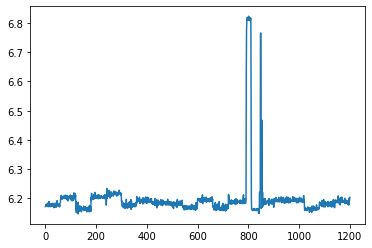

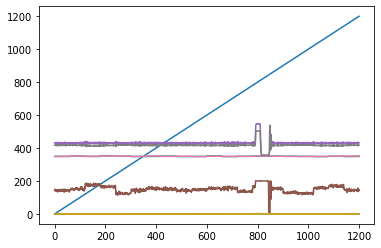

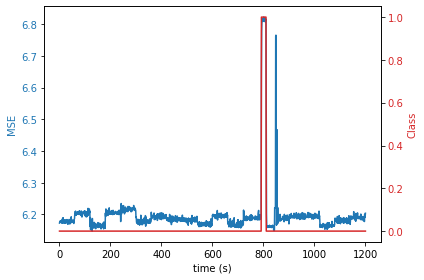

In [15]:
import numpy as np
import matplotlib.pyplot as plt



plt.plot(abnormal_events_df.mse)
plt.show()
df = pd.read_excel('Input Concentration Fault 1.xlsx',engine='openpyxl')
plt.plot(df)
plt.show()


df=df.Class
data1 = abnormal_events_mse
data2 = df

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Class', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

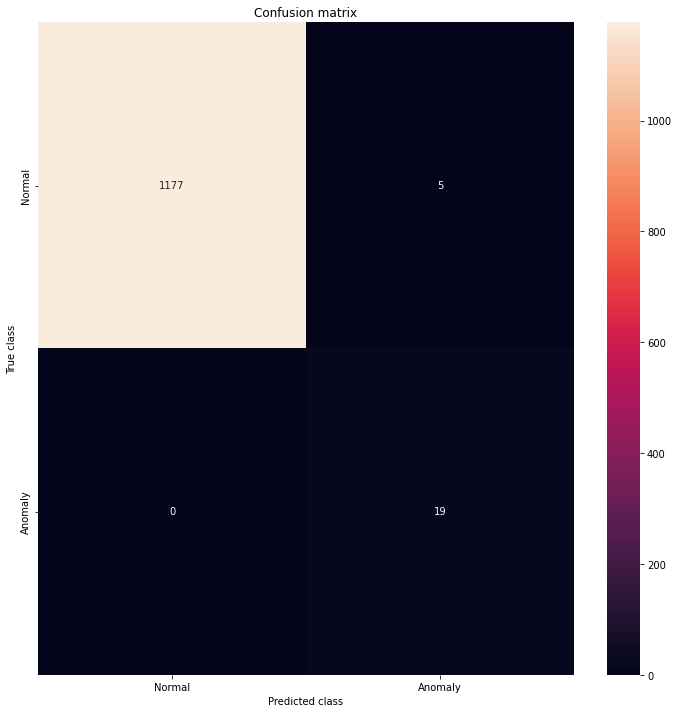

In [39]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

LABELS=["Normal", "Anomaly"]
conf_matrix = confusion_matrix(df.Class, Final.Class.astype(int))
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [46]:
import sklearn
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(df.Class, Final.Class.astype(int))
recall = recall_score(df.Class, Final.Class.astype(int))
f1_score = f1_score(df.Class, Final.Class.astype(int))
print(precision)
print(recall)
print(f1_score)

0.7916666666666666
1.0
0.8837209302325582


In [48]:
from sklearn.metrics import classification_report

target_names = ["Normal", "Anomaly"]
print(classification_report( df.Class, Final.Class.astype(int), target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1182
     Anomaly       0.79      1.00      0.88        19

    accuracy                           1.00      1201
   macro avg       0.90      1.00      0.94      1201
weighted avg       1.00      1.00      1.00      1201

